# The Product Pricer With Linear Regression

Traditional machine learning models that estimate how much a product costs based on extracted numeric features, such as weight, brand, text length, and popularity rank — rather than raw text descriptions.

## Purpose

To demonstrate multiple regression models that can predict prices from structured data, using Feature Linear Regression, Bag of Words, Word2Vec & Linear Regression, word2vec & SVR(Support Vector Regression), word2vec & Random Forest, and carry out performance comparison across different ML models

### Baseline Models

In [1]:
!pip install pandas numpy scikit-learn gensim huggingface-hub


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
### General Imports
import os
import math
import json
import random
from dotenv import load_dotenv
import matplotlib.pyplot as plt 
import pickle 
from collections import Counter
from huggingface_hub import login

/Volumes/VTG/Dev/C_5/Projects/week6/data_curation-optimization/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
### Imports For Traditional Machine Learning

import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [4]:
### For NLP related machine learning

from sklearn.feature_extraction.text import CountVectorizer 
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [5]:
### More of machine learning related ones
from sklearn.svm import LinearSVR 
from sklearn.ensemble import RandomForestRegressor 

In [6]:
### Internal Classes

from items import Item

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [7]:
### Constants -- used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"green": GREEN, "orange": YELLOW, "red": RED} 

In [8]:
### Environment 

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
HF_TOKEN_KEY = os.getenv("HF_TOKEN")

login(HF_TOKEN_KEY)


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [9]:
%matplotlib inline

## Loading the pkl files

In [10]:
with open("train.pkl", "rb") as f:
    train = pickle.load(f)

with open("test.pkl", "rb") as f:
    test = pickle.load(f)

In [11]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Sydney Rustic Mirror - Vanity Mirror, Bathroom Mirror, Farmhouse Decor, Wood Mirror, Large Mirror - 4 Sizes & 20 Colors - Red Oak
The Sydney low profile thin wood framed mirror will blend effortlessly in your current decor creating a simple yet sophisticated look. Our mirror features a reclaimed rustic styled wood finish, strong decorative lines with a thin 2.25” inch wide frame maximizing the visible mirror. This hanging mirror can be mounted horizontally or vertically. Available in 20 Colors - Shown in Red Oak. Not sure on color we do color samples please contact us for details. Available in 4 sizes, 24x30, 36x30, 42x30 & 60x30, all measurements are overall dimensions including frame and mirror. We offer two types

Price is $


In [12]:
print(test[0].price)

189.99


## Tester Class

In [13]:
class Tester: 

    def __init__(self, predictor, title=None, data=test, size=250): 
        self.predictor = predictor
        self.data = data
        ### Conditionally used for either the text report or chart's title
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.truths = []
        self.guesses = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth): 
        if error < 20 or error / truth < 0.2:
            return "green"
        elif error < 80 or error / truth < 0.4: 
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i): 
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth + 1) - math.log(guess + 1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) < 40 else datapoint.title[:40] + "..."
        self.truths.append(truth)
        self.guesses.append(guess)
        self.errors.append(error) 
        self.sles.append(sle) 
        self.colors.append(color) 
        print(f"{COLOR_MAP[color]}{i + 1}: Guess: ${guess:,.2f} | Truth: ${truth:,.2f} | Error: {error:,.2f} | SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title): 
        max_error = max(self.errors) 
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color="deepskyblue", lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val) 
        plt.title(title)
        plt.show()

    def report(self): 
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color == "green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits / self.size * 100:.1f}%"
        self.chart(title)

    def run(self):
        for i in range(self.size): 
            self.run_datapoint(i) 
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()


In [14]:
### Simulator function

def random_pricer(item): 
    return random.randrange(1, 1000)

1: Guess: $655.00 | Truth: $189.99 | Error: 465.01 | SLE: 1.52 Item: Sydney Rustic Mirror - Vanity Mirror, Ba...
2: Guess: $115.00 | Truth: $64.45 | Error: 50.55 | SLE: 0.33 Item: Kimax 45050-25200 N-51A Borosilicate Gla...
3: Guess: $26.00 | Truth: $128.99 | Error: 102.99 | SLE: 2.47 Item: FLAMMA FS21 Looper Pedal Drum Machine St...
4: Guess: $760.00 | Truth: $252.70 | Error: 507.30 | SLE: 1.21 Item: Xiaomi Poco X5 5G, Dual SIM, 265GB + 8GB...
5: Guess: $282.00 | Truth: $16.99 | Error: 265.01 | SLE: 7.59 Item: Vintage Farm Fresh Milk Stencil by Studi...
6: Guess: $251.00 | Truth: $499.99 | Error: 248.99 | SLE: 0.47 Item: HP 2021 Flagship 15 Laptop Computer 15.6...
7: Guess: $229.00 | Truth: $363.36 | Error: 134.36 | SLE: 0.21 Item: 3B Scientific G13 Heart w/ Oesophagus a....
8: Guess: $143.00 | Truth: $24.75 | Error: 118.25 | SLE: 2.96 Item: Noctua NF-F12 PWM chromax.Black.swap, Pr...
9: Guess: $755.00 | Truth: $65.20 | Error: 689.80 | SLE: 5.93 Item: Knitter's Pride Bamboo Knitting N

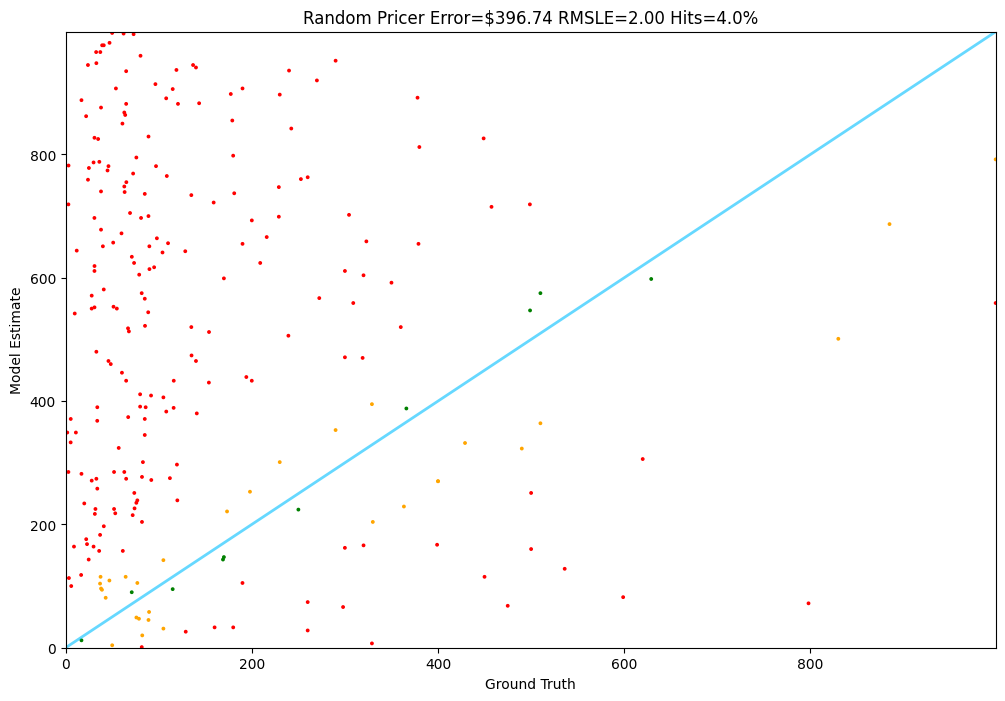

In [15]:
random.seed(42)

### Run Tester with a simulating guess predictor
Tester.test(random_pricer)

In [16]:
### Another test -- with average price from the train data

training_prices = [item.price for item in train]
training_avr_price = sum(training_prices) / len(training_prices)

def constant_pricer(item): 
    return training_avr_price 

1: Guess: $177.40 | Truth: $189.99 | Error: 12.59 | SLE: 0.00 Item: Sydney Rustic Mirror - Vanity Mirror, Ba...
2: Guess: $177.40 | Truth: $64.45 | Error: 112.95 | SLE: 1.01 Item: Kimax 45050-25200 N-51A Borosilicate Gla...
3: Guess: $177.40 | Truth: $128.99 | Error: 48.41 | SLE: 0.10 Item: FLAMMA FS21 Looper Pedal Drum Machine St...
4: Guess: $177.40 | Truth: $252.70 | Error: 75.30 | SLE: 0.12 Item: Xiaomi Poco X5 5G, Dual SIM, 265GB + 8GB...
5: Guess: $177.40 | Truth: $16.99 | Error: 160.41 | SLE: 5.26 Item: Vintage Farm Fresh Milk Stencil by Studi...
6: Guess: $177.40 | Truth: $499.99 | Error: 322.59 | SLE: 1.07 Item: HP 2021 Flagship 15 Laptop Computer 15.6...
7: Guess: $177.40 | Truth: $363.36 | Error: 185.96 | SLE: 0.51 Item: 3B Scientific G13 Heart w/ Oesophagus a....
8: Guess: $177.40 | Truth: $24.75 | Error: 152.65 | SLE: 3.75 Item: Noctua NF-F12 PWM chromax.Black.swap, Pr...
9: Guess: $177.40 | Truth: $65.20 | Error: 112.20 | SLE: 0.98 Item: Knitter's Pride Bamboo Knitting Ne

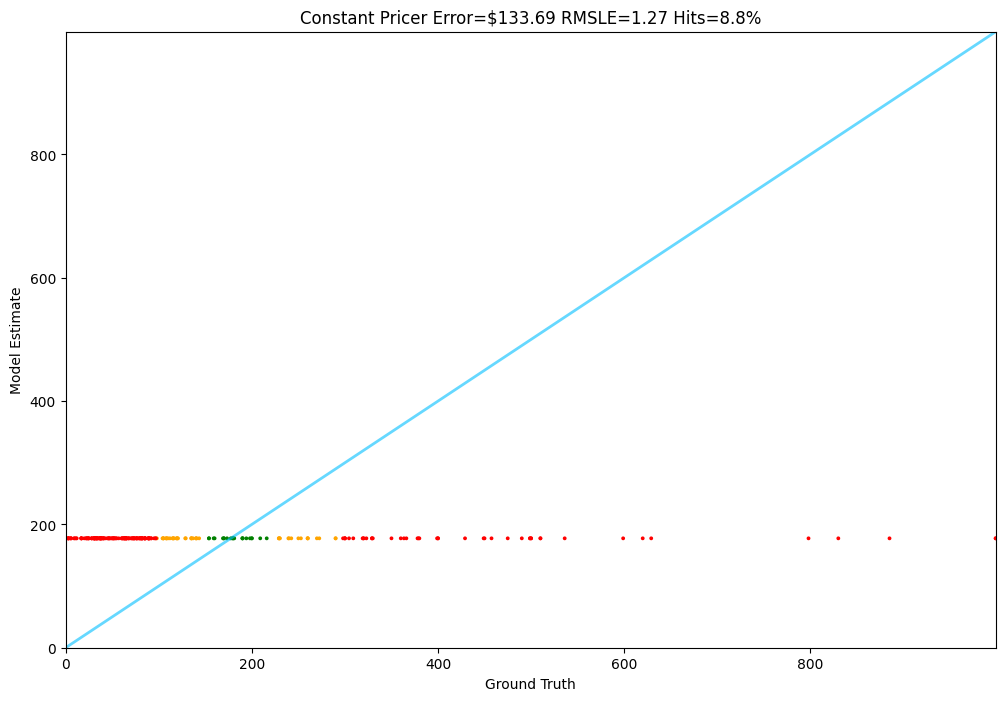

In [17]:
Tester.test(constant_pricer)

## Feature Engineering

Demonstrate feature engineering using product weights, brand, and other fields 
to.

In [18]:
train[0].details

'{"Package Dimensions": "12.4 x 10.08 x 7.76 inches", "Item Weight": "5.33 pounds", "Item model number": "MS300", "Best Sellers Rank": {"Photographic Lighting Monolights": 296}, "Date First Available": "August 4, 2019", "Manufacturer": "Godox", "Brand": "GODOX", "Compatible Mountings": "Nikon", "Camera Flash": "Studio", "Included Components": "MS Flash Head *1 Power Cord *1 Lamp Cover *1", "Wireless Communication Technology": "Optical Pulse"}'

In [19]:
### Create a new "features" field on items, 
### and populate it with json parsed from the details dict

for item in train: 
    item.features = json.loads(item.details)

for item in test: 
    item.features = json.loads(item.details)

In [20]:
print(train[0].features.keys())

dict_keys(['Package Dimensions', 'Item Weight', 'Item model number', 'Best Sellers Rank', 'Date First Available', 'Manufacturer', 'Brand', 'Compatible Mountings', 'Camera Flash', 'Included Components', 'Wireless Communication Technology'])


In [21]:
### Look at 20 most common features in training set

feature_count = Counter()

for item in train: 
    for f in item.features.keys(): 
        feature_count[f] += 1

feature_count.most_common(20)

[('Item Weight', 180480),
 ('Date First Available', 176260),
 ('Manufacturer', 172893),
 ('Best Sellers Rank', 157663),
 ('Item model number', 156533),
 ('Brand', 149365),
 ('Product Dimensions', 143132),
 ('Is Discontinued By Manufacturer', 99915),
 ('Color', 84712),
 ('Material', 56543),
 ('Country of Origin', 52131),
 ('Package Dimensions', 52033),
 ('Manufacturer recommended age', 42495),
 ('Item Dimensions LxWxH', 35079),
 ('Special Feature', 32950),
 ('Model Name', 28393),
 ('Connectivity Technology', 25923),
 ('Batteries', 24674),
 ('Compatible Devices', 23240),
 ('Item Dimensions  LxWxH', 20308)]

### Product Weights

In [22]:
# Some janky code to pluck out the Item Weight

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [23]:
weights = [get_weight(t) for t in test]

### Filter out None values (if w)
weights = [w for w in weights if w]

In [24]:
average_weight = sum(weights) / len(weights)
print(f"Avr Weight: {average_weight:.2f}")

Avr Weight: 5.71


In [25]:
### Set default weight for items with None value for weights
def get_defualt_weight(item): 
    weight = get_weight(item)
    return weight or average_weight

In [26]:
w = get_weight(train[1000])
print(w)

1.38


### Best Seller Ranks 

In [27]:
def get_rank(item): 
    """
    Get an average rank per item out of multiple ranks across different categories.
    """
    ### A product has ranks across multiple categories in Amazon data
    ranks_dict = item.features.get("Best Sellers Rank")
    if ranks_dict:
        ranks = ranks_dict.values()
        avr_rank = sum(ranks) / len(ranks)
        return avr_rank
        
    return None
    
    

In [28]:
get_rank(train[100])

323746.0

In [29]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]

average_rank = sum(ranks) / len(ranks)
print(f"Average Rank = {average_rank:,.2f}")

Average Rank = 123,129.66


In [30]:
def get_default_rank(item): 
    rank = get_rank(item)
    return rank or average_rank

In [31]:
def get_text_length(item): 
    return len(item.prompt)

In [32]:
### Look at 40 most common brands

brand_counts = Counter()

for t in train: 
    brand = t.features.get("Brand")
    if brand: 
        brand_counts[brand] += 1 

print(brand_counts.most_common(40))

[('HP', 4484), ('Dell', 3189), ('Lenovo', 2401), ('SAMSUNG', 1795), ('ASUS', 1377), ('Sony', 1309), ('Funko', 831), ('Canon', 815), ('Apple', 784), ('Intel', 669), ('Magic The Gathering', 637), ('Generic', 604), ('Nikon', 534), ('Garmin', 483), ('Pyle', 482), ('Panasonic', 448), ('MSI', 435), ('LG', 434), ('Rockville', 427), ('GODOX', 423), ('Microsoft', 414), ('Acer', 364), ('Fender', 336), ('AmScope', 317), ('Pokemon', 316), ('KICKER', 316), ('Yu-Gi-Oh!', 306), ('Logitech', 294), ('Gigabyte', 280), ('Harmony Audio', 277), ('Audio-Technica', 263), ('Fujifilm', 261), ('Western Digital', 248), ('Plantronics', 244), ('Ibanez', 243), ('acer', 241), ('Olympus', 235), ('DJI', 231), ('Bose', 229), ('Seagate', 229)]


In [33]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]

def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

print(is_top_electronics_brand(train[2300]))

True


### Result: get_features()

In [34]:
def get_features(item): 
    """
    Return weight, rank, text_length, and whether it's one of top electronics brands in a dictionary form
    """
    return {
        "weight": get_defualt_weight(item), 
        "rank": get_default_rank(item), 
        "text_length": get_text_length(item), 
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0 
    }

In [35]:
get_features(train[0])

{'weight': 5.33,
 'rank': 296.0,
 'text_length': 723,
 'is_top_electronics_brand': 0}

## Linear Regression with Features

In [36]:
# A utility function to convert the features(dict) into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    ### Add price label
    df["price"] = [item.price for item in items]

    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

240 Tons


In [37]:
print(test_df[:10])

     weight           rank  text_length  is_top_electronics_brand   price
0  5.714881  123129.660484          791                         0  189.99
1  5.714881  123129.660484          624                         0   64.45
2  1.210000  123129.660484          730                         0  128.99
3  1.080000  123129.660484          656                         0  252.70
4  5.714881  163266.500000          758                         0   16.99
5  5.714881  123129.660484          611                         1  499.99
6  5.714881  123129.660484          773                         0  363.36
7  0.681250      50.000000          723                         0   24.75
8  0.249375   36394.000000          690                         0   65.20
9  3.000000   47698.666667          666                         1  189.95


In [38]:
### Traditional Linear Regression

np.random.seed(42)

### Separate features and target 
feature_columns = ["weight", "rank", "text_length", "is_top_electronics_brand"]

X_train = train_df[feature_columns]
y_train = train_df["price"]

X_test = test_df[feature_columns]
y_test = test_df["price"]

### Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

print(model.coef_)

### Print pairs of feature_columns and coefficients 
print("\n|==Metrics Report==|\n")
for features, coef in zip(feature_columns, model.coef_): 
    print(f"{features}: {coef}")

### Intercept rate
print(f"Intercept: {model.intercept_}")


### Predict the test set and evaluate (with error metrics)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squred Error: {mse}")
print(f"R-Squared Score: {r2}")

### Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    
    return model.predict(features_df)[0]

[ 9.64013373e-01 -1.21243045e-04 -1.85446479e-02  2.22721213e+02]

|==Metrics Report==|

weight: 0.964013372775741
rank: -0.00012124304524521762
text_length: -0.018544647929444123
is_top_electronics_brand: 222.72121295691014
Intercept: 183.96637572726362
Mean Squred Error: 25103.209953520036
R-Squared Score: 0.1659497428401624


1: Guess: $159.88 | Truth: $189.99 | Error: 30.11 | SLE: 0.03 Item: Sydney Rustic Mirror - Vanity Mirror, Ba...
2: Guess: $162.98 | Truth: $64.45 | Error: 98.53 | SLE: 0.84 Item: Kimax 45050-25200 N-51A Borosilicate Gla...
3: Guess: $156.67 | Truth: $128.99 | Error: 27.68 | SLE: 0.04 Item: FLAMMA FS21 Looper Pedal Drum Machine St...
4: Guess: $157.91 | Truth: $252.70 | Error: 94.79 | SLE: 0.22 Item: Xiaomi Poco X5 5G, Dual SIM, 265GB + 8GB...
5: Guess: $155.62 | Truth: $16.99 | Error: 138.63 | SLE: 4.68 Item: Vintage Farm Fresh Milk Stencil by Studi...
6: Guess: $385.94 | Truth: $499.99 | Error: 114.05 | SLE: 0.07 Item: HP 2021 Flagship 15 Laptop Computer 15.6...
7: Guess: $160.21 | Truth: $363.36 | Error: 203.15 | SLE: 0.66 Item: 3B Scientific G13 Heart w/ Oesophagus a....
8: Guess: $171.21 | Truth: $24.75 | Error: 146.46 | SLE: 3.61 Item: Noctua NF-F12 PWM chromax.Black.swap, Pr...
9: Guess: $167.00 | Truth: $65.20 | Error: 101.80 | SLE: 0.87 Item: Knitter's Pride Bamboo Knitting Nee

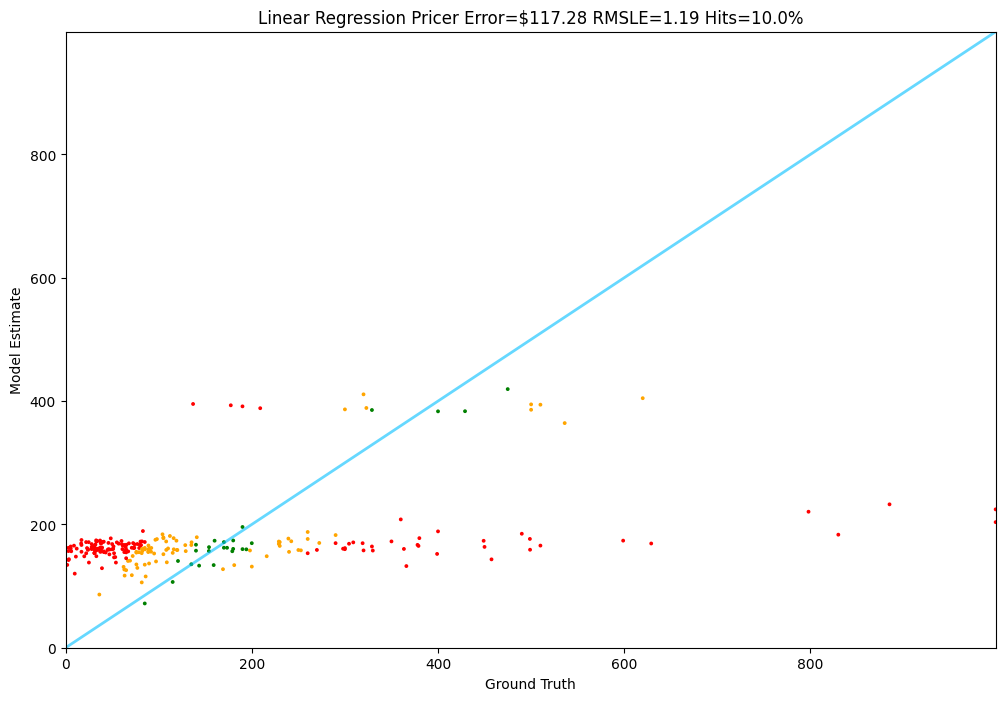

In [39]:
Tester.test(linear_regression_pricer)

## Bag of Words (NLP)

Using the Bag of Words (BoW) model, the results showed more than twice the improvement compared to the feature engineering approach.
(hits: 10% TO 24%)

In [40]:
### X and y elements
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [41]:
# np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [42]:
def bow_lr_pricer(item): 
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $61.14 | Truth: $189.99 | Error: 128.85 | SLE: 1.26 Item: Sydney Rustic Mirror - Vanity Mirror, Ba...
2: Guess: $100.08 | Truth: $64.45 | Error: 35.63 | SLE: 0.19 Item: Kimax 45050-25200 N-51A Borosilicate Gla...
3: Guess: $261.45 | Truth: $128.99 | Error: 132.46 | SLE: 0.49 Item: FLAMMA FS21 Looper Pedal Drum Machine St...
4: Guess: $340.87 | Truth: $252.70 | Error: 88.17 | SLE: 0.09 Item: Xiaomi Poco X5 5G, Dual SIM, 265GB + 8GB...
5: Guess: $53.38 | Truth: $16.99 | Error: 36.39 | SLE: 1.22 Item: Vintage Farm Fresh Milk Stencil by Studi...
6: Guess: $690.31 | Truth: $499.99 | Error: 190.32 | SLE: 0.10 Item: HP 2021 Flagship 15 Laptop Computer 15.6...
7: Guess: $117.05 | Truth: $363.36 | Error: 246.31 | SLE: 1.27 Item: 3B Scientific G13 Heart w/ Oesophagus a....
8: Guess: $185.97 | Truth: $24.75 | Error: 161.22 | SLE: 3.93 Item: Noctua NF-F12 PWM chromax.Black.swap, Pr...
9: Guess: $139.15 | Truth: $65.20 | Error: 73.95 | SLE: 0.56 Item: Knitter's Pride Bamboo Knitting Needl

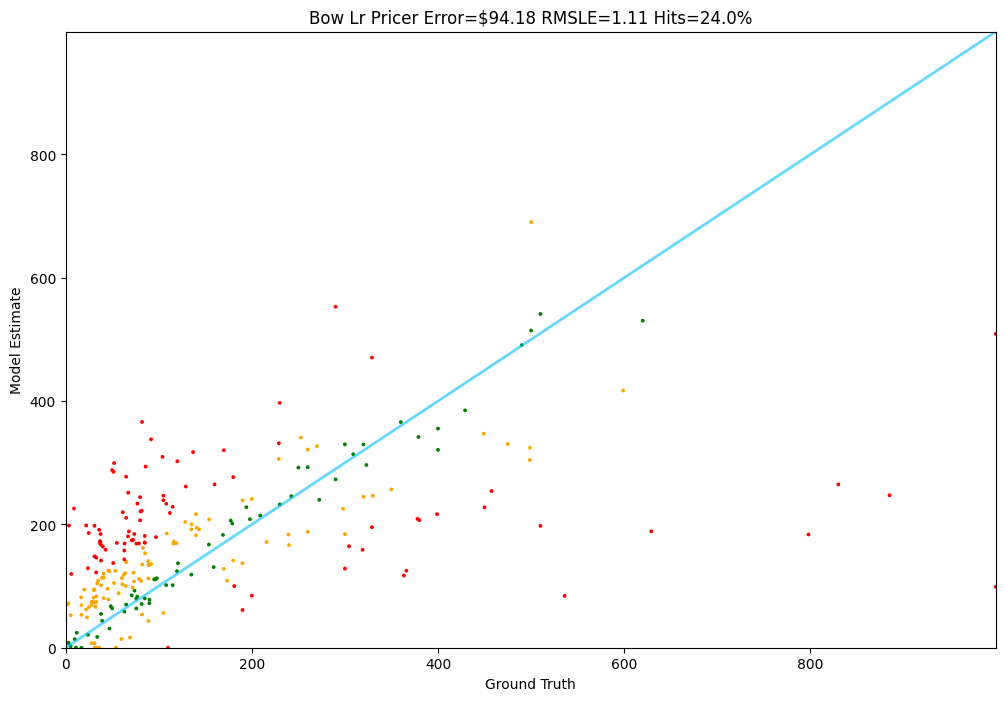

In [43]:
Tester.test(bow_lr_pricer)

## word2vec model

In [44]:
### word2vec model implemented in gensim NLP library

np.random.seed(42)

### Prepare the documents: (test_prompt used in the BoW model above)
processed_docs = [simple_preprocess(doc) for doc in documents]

### Train Word2Vec model: 
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [45]:
### Note: This step of averaging vectors across the document is a weakness in this approach

def document_vector(doc): 
    doc_words = simple_preprocess(doc) ### split words and store
    ### convert the split words into numeric representations (vectors)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

### Create feature matrix: 
X_w2v = np.array([document_vector(doc) for doc in documents])

In [46]:
# print(w2v_model.wv["computer"])
print(w2v_model.wv["computer"].shape)

(400,)


In [47]:
### Run Linear Regression on word2vec 

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [48]:
def word2vec_lr_pricer(item): 
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $115.48 | Truth: $189.99 | Error: 74.51 | SLE: 0.24 Item: Sydney Rustic Mirror - Vanity Mirror, Ba...
2: Guess: $116.02 | Truth: $64.45 | Error: 51.57 | SLE: 0.34 Item: Kimax 45050-25200 N-51A Borosilicate Gla...
3: Guess: $224.70 | Truth: $128.99 | Error: 95.71 | SLE: 0.30 Item: FLAMMA FS21 Looper Pedal Drum Machine St...
4: Guess: $325.15 | Truth: $252.70 | Error: 72.45 | SLE: 0.06 Item: Xiaomi Poco X5 5G, Dual SIM, 265GB + 8GB...
5: Guess: $88.06 | Truth: $16.99 | Error: 71.07 | SLE: 2.56 Item: Vintage Farm Fresh Milk Stencil by Studi...
6: Guess: $593.69 | Truth: $499.99 | Error: 93.70 | SLE: 0.03 Item: HP 2021 Flagship 15 Laptop Computer 15.6...
7: Guess: $157.57 | Truth: $363.36 | Error: 205.79 | SLE: 0.69 Item: 3B Scientific G13 Heart w/ Oesophagus a....
8: Guess: $227.44 | Truth: $24.75 | Error: 202.69 | SLE: 4.76 Item: Noctua NF-F12 PWM chromax.Black.swap, Pr...
9: Guess: $119.09 | Truth: $65.20 | Error: 53.89 | SLE: 0.35 Item: Knitter's Pride Bamboo Knitting Needles

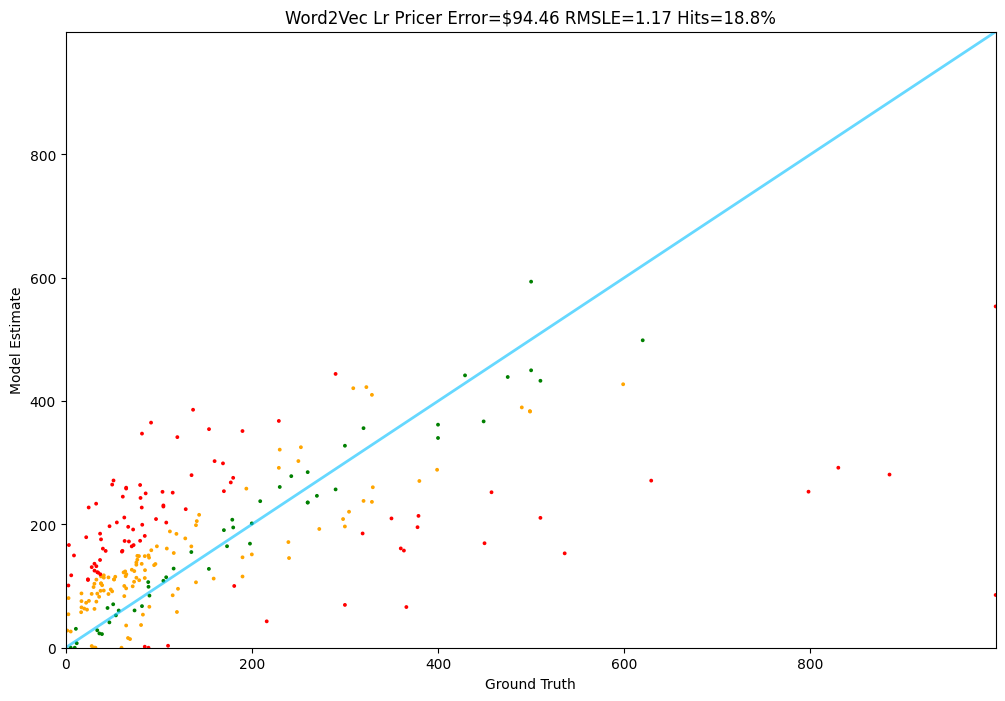

In [49]:
Tester.test(word2vec_lr_pricer)

## Support Vector Machines with a W2V model

In [50]:
np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [51]:
# function that receives an item argument 
# take out a test prompt from item
# vectorize it
# predict using svr_regressor instance

def svr_pricer(item): 
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]), 0)

1: Guess: $88.32 | Truth: $189.99 | Error: 101.67 | SLE: 0.58 Item: Sydney Rustic Mirror - Vanity Mirror, Ba...
2: Guess: $75.58 | Truth: $64.45 | Error: 11.13 | SLE: 0.02 Item: Kimax 45050-25200 N-51A Borosilicate Gla...
3: Guess: $170.26 | Truth: $128.99 | Error: 41.27 | SLE: 0.08 Item: FLAMMA FS21 Looper Pedal Drum Machine St...
4: Guess: $253.26 | Truth: $252.70 | Error: 0.56 | SLE: 0.00 Item: Xiaomi Poco X5 5G, Dual SIM, 265GB + 8GB...
5: Guess: $61.32 | Truth: $16.99 | Error: 44.33 | SLE: 1.54 Item: Vintage Farm Fresh Milk Stencil by Studi...
6: Guess: $501.98 | Truth: $499.99 | Error: 1.99 | SLE: 0.00 Item: HP 2021 Flagship 15 Laptop Computer 15.6...
7: Guess: $133.52 | Truth: $363.36 | Error: 229.84 | SLE: 0.99 Item: 3B Scientific G13 Heart w/ Oesophagus a....
8: Guess: $143.06 | Truth: $24.75 | Error: 118.31 | SLE: 2.96 Item: Noctua NF-F12 PWM chromax.Black.swap, Pr...
9: Guess: $81.36 | Truth: $65.20 | Error: 16.16 | SLE: 0.05 Item: Knitter's Pride Bamboo Knitting Needles ...

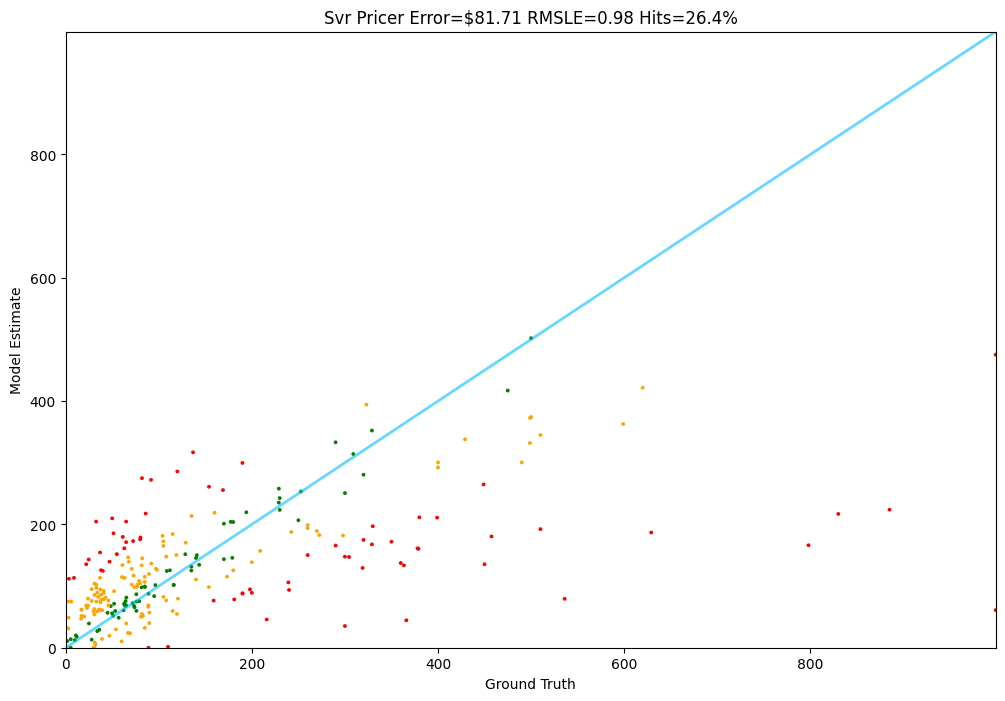

In [52]:
Tester.test(svr_pricer)

## Random Forest Regression with a W2V model

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

In [ ]:
def random_forest_pricer(item): 
    doc = item.test_prompt()
    doc_vector = document_vector(doc) 
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(random_forest_pricer)